![NVIDIA Logo](images/nvidia.png)

# PubMedQA With Zero-Shot Prompts

In this notebook we'll obtain baseline performances for several of our available LLMs by performing and evaluating zero shot prompting on the PubMedQA question answering task.

---

## Learning Objectives

By the time you complete this notebook you will:
- Format the raw PubMedQA data to be more suitable for prompting.
- Evaluate zero-shot performance for 3 GPT models on PubMedQA Data.

---

## Imports

In [1]:
import json

from tqdm.notebook import tqdm

from llm_utils.nemo_service_models import NemoServiceBaseModel
from llm_utils.models import PubmedModels
from llm_utils.helpers import plot_experiment_results, accuracy_score
from llm_utils.pubmedqa import strip_response

---

## List Models

While working with the PubMedQA data, we will be using several of the GPT models provided to us by NeMo Service, which we've collected for you in the `PubmedModels` enum.

In [2]:
PubmedModels.list_models()

gpt8b: gpt-8b-000
gpt20b: gpt20b
gpt43b: gpt-43b-001


---

## PubMedQA for Customization Evaluation

The PubMedQA question answering task will require our models to both perform reasoning using a lot of very specialized terminology, and also format responses in a very specific way. Additionally it is clear and well-labeled dataset. For these reasons it will serve us well as an entrypoint into PEFT, providing us not only the data needed for PEFT fine-tuning, but also as an opportunity to observe performance across a variety of models and customization techniques including zero and few-shot prompting, which will help us make a thorough quantitative analysis of how PEFT can benefit our use of these LLMs.

---

## Load Training Data

Here we load the test split of the PubMedQA data created in the last notebook, which will give us a dictionary of 150 entries.

In [3]:
pubmedqa_data = json.load(open('data/pubmedqa_test.json','r'))

In [4]:
type(pubmedqa_data)

dict

In [5]:
len(pubmedqa_data)

150

Here we print the first entry in the test data.

In [6]:
list(pubmedqa_data.values())[0]

{'QUESTION': "The English antibiotic awareness campaigns: did they change the public's knowledge of and attitudes to antibiotic use?",
 'CONTEXTS': ['To determine the effect of the 2008 English public antibiotic campaigns.',
  'English and Scottish (acting as controls) adults aged>or = 15 years were questioned face to face about their attitudes to and use of antibiotics, in January 2008 (1888) before and in January 2009 (1830) after the antibiotic campaigns.',
  'Among English respondents, there was a small increase in recollection of campaign posters (2009 23.7% versus 2008 19.2%; P = 0.03), but this increase was only 2.3% higher in England than in Scotland. We did not detect any improvement in either England or Scotland, or any differences between England and Scotland in the understanding of the lack of benefit of antibiotics for coughs and colds, and we found no improvement in antibiotic use. We detected a significant increase in respondents retaining leftover antibiotics. Over 20% 

---

## Process Data in Prep for Prompting

Given the printout we just saw, let's reformat the data to be in a more suitable format for prompting. To do this we'll use `generate_prompts_with_answers` which for a given PubMedQA data entry will return a 2-tuple containing a prompt-formatted version of the entry, and its corresponding label.

We've created this prompt format for you but please keep in mind as you go out to work with your own data that any time you need to convert data into a prompt for an LLM, time and care should be taken with the prompt engineering process to arrive at prompts that work well for your situation.

In [7]:
def generate_prompts_with_answers(data):
    prompt = ""
    for index, context in enumerate(data['CONTEXTS']):
        section_label = data['LABELS'][index]
        prompt += f"{section_label}: {context}\n"
    
    question_text = data['QUESTION']
    prompt += f"QUESTION: {question_text}\n"
    prompt += f"ANSWER (yes|no|maybe): "

    label = data['final_decision']
    
    return (prompt, label)

In [8]:
prompts_and_answers = []
for value in pubmedqa_data.values():
    prompts_and_answers.append(generate_prompts_with_answers(value))

In [9]:
len(prompts_and_answers)

150

In [10]:
sample_prompt = prompts_and_answers[0][0]
sample_answer = prompts_and_answers[0][1]

In [11]:
print(sample_prompt)

OBJECTIVES: To determine the effect of the 2008 English public antibiotic campaigns.
METHODS: English and Scottish (acting as controls) adults aged>or = 15 years were questioned face to face about their attitudes to and use of antibiotics, in January 2008 (1888) before and in January 2009 (1830) after the antibiotic campaigns.
RESULTS: Among English respondents, there was a small increase in recollection of campaign posters (2009 23.7% versus 2008 19.2%; P = 0.03), but this increase was only 2.3% higher in England than in Scotland. We did not detect any improvement in either England or Scotland, or any differences between England and Scotland in the understanding of the lack of benefit of antibiotics for coughs and colds, and we found no improvement in antibiotic use. We detected a significant increase in respondents retaining leftover antibiotics. Over 20% reported discussing antibiotics with their general practitioner (GP) or nurse in the year to January 2009. The offer of a delayed 

In [12]:
sample_answer

'no'

---

## Write Formatted Prompts and Answers to File

We will be reusing `prompts_and_answers` in the next several notebooks so here we write it to file for easy re-use.

In [13]:
with open('data/pubmedqa_panda_test.json', 'w') as f:
    json.dump(prompts_and_answers, f)

---

## Try Zero-shot Prompting

We will begin our PubMedQA experiments with zero shot attempts using a GPT43B model.

In [14]:
gpt43b = NemoServiceBaseModel(PubmedModels.gpt43b.value)

Because answers are expected to be `yes`, `no`, or `maybe` we limit token generation to 1 token.

In [15]:
for prompt, answer in prompts_and_answers[::45]:
    response = gpt43b.generate(prompt, tokens_to_generate=1)
    print(f'Response from model: {response}')
    print(f'Actual answer: {answer}')
    correct = response == answer
    print(f'Response from model correct: {correct}\n')

Response from model:  no
Actual answer: no
Response from model correct: False

Response from model:  no
Actual answer: no
Response from model correct: False

Response from model:  yes
Actual answer: yes
Response from model correct: False

Response from model:  no
Actual answer: no
Response from model correct: False



We can see that the model did well with this small sample of answers in terms of generating the correct answer, however, it did insert some extra white space.

Part of what we want to evaluate a fine-tuned model on is its ability to generate well-formatted responses, so with that in mind we do not, for the sake of these experiments, want to do a lot of post-processing. However, let's agree that stripping white space is almost always okay and do that here.

In [16]:
for prompt, answer in prompts_and_answers[::45]:
    response = gpt43b.generate(prompt, tokens_to_generate=1).strip() # Strip white space
    print(f'Response from model: {response}')
    print(f'Actual answer: {answer}')
    correct = response == answer
    print(f'Response from model correct: {correct}\n')

Response from model: no
Actual answer: no
Response from model correct: True

Response from model: no
Actual answer: no
Response from model correct: True

Response from model: yes
Actual answer: yes
Response from model correct: True

Response from model: no
Actual answer: no
Response from model correct: True



At least with this small sample size, GPT43B appears to do very well with the PubMedQA task.

---

## Experiment with Several GPT Models

To get a better sample size of performance for our experiements, let's go ahead and utilize 3 different-sized GPT models. Here we create a dictionary `llms` containing all 3 of the GPT model instance types loaded into this notebook.

In [17]:
llms = {model.name: NemoServiceBaseModel(model.value) for model in PubmedModels}

In [ ]:
llms

Now we will perform a sanity check for all of them on the first 3 samples.

In [18]:
for name, llm in llms.items():
    underline = "-"*len(name)
    print(f'{name.upper()}\n{underline}\n')
    
    for prompt, answer in prompts_and_answers[:3]:
        response = llm.generate(prompt, tokens_to_generate=1).strip()
        print(f'Response from model: {response}')
        print(f'Actual answer: {answer}')
        correct = response == answer
        print(f'Response from model correct: {correct}\n')

GPT8B
-----

Response from model: 1
Actual answer: no
Response from model correct: False

Response from model: 1
Actual answer: yes
Response from model correct: False

Response from model: 1
Actual answer: yes
Response from model correct: False

GPT20B
------

Response from model: Yes
Actual answer: no
Response from model correct: False

Response from model: Yes
Actual answer: yes
Response from model correct: False

Response from model: yes
Actual answer: yes
Response from model correct: True

GPT43B
------

Response from model: no
Actual answer: no
Response from model correct: True

Response from model: yes
Actual answer: yes
Response from model correct: True

Response from model: yes
Actual answer: yes
Response from model correct: True



### Analysis

So far the 8B model gave us complete junk, the 20B model gave us somewhat well formatted but not always correct responses, and the 43B model appears to be doing great.

---

## The NemoServiceBaseModel Evaluate Method

Our `NemoServiceBaseModel` has an `evaluate` method we will be using. In its most simple form we can simply pass it a list of 2-tuples containing prompt/label pairs (like `prompts_and_answers`) and it will generate a response for every prompt, check the response against the label, and at the end of its run print an accuracy score for the run.

Since evaluate is calling `generate` under the hood, we can also pass in other generation parameters like `tokens_to_generate`, `top_k`, etc.

In [19]:
gpt43b.evaluate(prompts_and_answers[:3], tokens_to_generate=1)

  0%|          | 0/3 [00:00<?, ?it/s]

0/3 correct
Accuracy: 0.00


'0.00'

---

## Post Processing With Evaluate

By default `evaluate` will not perform any post processing on the model output. With what we observed above, it makes sense that `gpt43b` scored 0 on the first 2 samples since we know it is including some white space at the beginning of the response.

If we'd like we can pass a `get_clean_prediction` function to `evaluate` which should expect a model response string, perform some post-processing on it, and return the results which are then compared to the provided label.

For our case let's use the following `strip_response` function to trim white space off the responses before comparing them to their labels.

In [20]:
def strip_response(response: str) -> str:
    return response.strip()

In [21]:
gpt43b.evaluate(prompts_and_answers[:3], get_clean_prediction=strip_response, tokens_to_generate=1)

  0%|          | 0/3 [00:00<?, ?it/s]

3/3 correct
Accuracy: 1.00


'1.00'

Having stripped off the white space we see the GPT43B model performing as well as we observed above.

It's worth mentioning that the intended use of `evaluate` is to evaluate model performance across datasets and is not a replacement for `generate`. If you need to view individual model responses for any reason, switch to using `generate` on the data samples in question so you can see model output directly.

---

## Try Zero-shot Prompting With Full Dataset

Now we will iterate through all 3 GPT models and evaluate their performance on our test set. In doing so we will also introduce another feature of the `generate` method which is to write evaluation results to a csv file. Later we will visualize the results to better observe how each of the models perform in different prompting and fine-tuning scenarios.

We will be writing to `'experiment_results/pubmed_experiment_results.csv'`. This file will contain results for all of our experiments with the PubMedQA data including zero, one and few-shot prompting, p-tuning and LoRA, with a variety of models.

The model instance itself will provide the model name to the experiment results file, so we don't need to pass that in manually. We supply `experiment_name` to specify the customization conditions for this particular run, in our case, "Zero Shot".

The following, which runs the whole `prompts_and_answers` dataset through 3 GPT models will take a minute or two to complete.

In [22]:
for name, llm in tqdm(llms.items()):
    underline = "-"*len(name)
    print(f'{name.upper()}\n{underline}\n')
    
    llm.evaluate(prompts_and_answers,
                get_clean_prediction=strip_response,
                write_results_to_csv=True,
                experiment_name='Zero Shot',
                csv_file_name='experiment_results/pubmed_experiment_results.csv',
                tokens_to_generate=1)
    print()

  0%|          | 0/3 [00:00<?, ?it/s]

GPT8B
-----



  0%|          | 0/150 [00:00<?, ?it/s]

0/150 correct
Accuracy: 0.00

GPT20B
------



  0%|          | 0/150 [00:00<?, ?it/s]

22/150 correct
Accuracy: 0.15

GPT43B
------



  0%|          | 0/150 [00:00<?, ?it/s]

117/150 correct
Accuracy: 0.78



---

## View Results

In addition to the printouts above, each model instance has an `experiment_results` property we can inspect.

In [23]:
for llm in llms.values():
    print(llm.experiment_results)

{'Zero Shot': {'gpt-8b-000': '0.00'}}
{'Zero Shot': {'gpt20b': '0.15'}}
{'Zero Shot': {'gpt-43b-001': '0.78'}}


Additionally, we have provided a `plot_experiment_results` helper for better visualization, especially when we start to conduct multiple experiments.

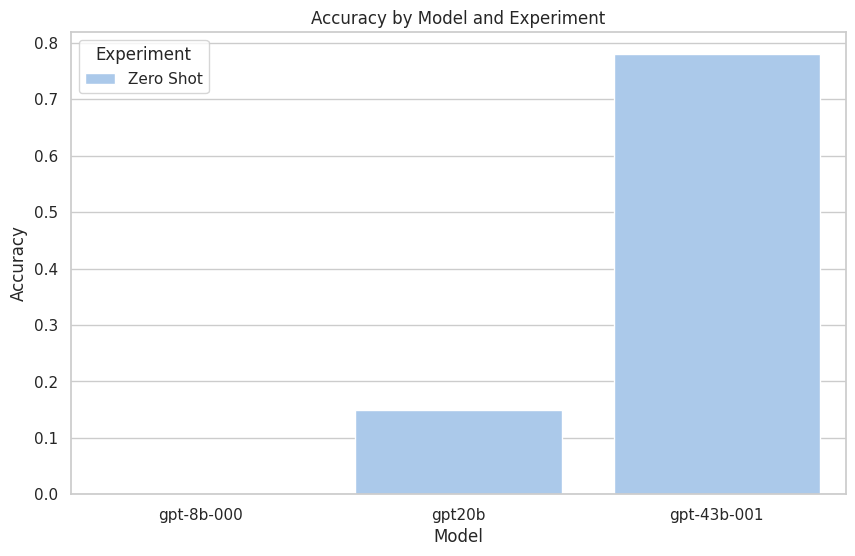

In [24]:
plot_experiment_results('experiment_results/pubmed_experiment_results.csv')

# We also provide solution/reference results in case they are needed.
# plot_experiment_results('experiment_results/solutions/zero_shot_pubmed_experiment_results.csv')

---

## Analysis

Much like we observed above with the small sample size, the model's have performed to varying degrees, largely relative to their size. 43B appears to be doing quite well, 20B didn't fail entirely, but only got some responses correct, and 8B didn't get a single response correct.